- https://docs.rapids.ai/api/cudf/stable/10min.html
- https://www.dataquest.io/blog/data-science-portfolio-machine-learning/
- https://docs.dask.org/en/latest/dataframe-best-practices.html
- #!conda create -n rapids-0.16 -c rapidsai -c nvidia -c conda-forge -c defaults rapids=0.16 python=3.7 cudatoolkit=11.0 matplotlib=3.3.3 gcsfs=0.7.1


In [ ]:
%%bash
nvidia-smi
nvcc --version

In [1]:
import numpy as np; print('numpy Version:', np.__version__)
import pandas as pd; print('pandas Version:', pd.__version__)
import xgboost as xgb; print('XGBoost Version:', xgb.__version__)
import cudf; print('cudf Version:', cudf.__version__)
import cuml; print('cudf Version:', cuml.__version__)
import gcsfs; print('gcsfs Version:', gcsfs.__version__)
import time
import dask_cudf; print('dask_cudf Version:', gcsfs.__version__)
import dask; print('dask Version:', gcsfs.__version__)
import dask.dataframe as dask_df
import glob;
import matplotlib; print('matplotlib Version:', matplotlib.__version__)

numpy Version: 1.19.4
pandas Version: 1.1.5
XGBoost Version: 1.3.0-SNAPSHOT
cudf Version: 0.16.0
cudf Version: 0.16.0
gcsfs Version: 0.7.1
dask_cudf Version: 0.7.1
dask Version: 0.7.1
matplotlib Version: 3.3.2


In [2]:
col_acq = ['LoanID','Channel','SellerName','OrInterestRate','OrUnpaidPrinc','OrLoanTerm',
        'OrDate','FirstPayment','OrLTV','OrCLTV','NumBorrow','DTIRat','CreditScore',
        'FTHomeBuyer','LoanPurpose','PropertyType','NumUnits','OccStatus','PropertyState',
        'Zip','MortInsPerc','ProductType','CoCreditScore','MortInsType','RelMortInd'];

col_per = ['LoanID','MonthRep','Servicer','CurrInterestRate','CAUPB','LoanAge','MonthsToMaturity',
          'AdMonthsToMaturity','MaturityDate','MSA','CLDS','ModFlag','ZeroBalCode','ZeroBalDate',
          'LastInstallDate','ForeclosureDate','DispositionDate','PPRC','AssetRecCost','MHRC',
          'ATFHP','NetSaleProceeds','CreditEnhProceeds','RPMWP','OFP','NIBUPB','PFUPB','RMWPF',
          'FPWA','ServicingIndicator'];



dtype_acq={
   "LoanID":"object",
   "Channel":"object",
   "SellerName":"float64",
   "OrInterestRate":"int64",
   "OrUnpaidPrinc":"int64",
   "OrLoanTerm":"object",
   "OrDate":"object",
   "FirstPayment":"int64",
   "OrLTV":"int64",
   "OrCLTV":"int64",
   "NumBorrow":"float64",
   "DTIRat":"float64",
   "CreditScore":"object",
   "FTHomeBuyer":"object",
   "LoanPurpose":"object",
   "PropertyType":"int64",
   "NumUnits":"object",
   "OccStatus":"object",
   "PropertyState":"int64",
   "Zip":"float64",
   "MortInsPerc":"object",
   "ProductType":"float64",
   "CoCreditScore":"float64",
   "MortInsType":"object",
   "RelMortInd":"int6"
}


dtype_perf={
   "LoanID":"str",
   "MonthRep":"datetime",
   "Servicer":"str",
   "CurrInterestRate":"float",
   "CAUPB":"float",
   "LoanAge":"float",
   "MonthsToMaturity":"float",
   "AdMonthsToMaturity":"float",
   "MaturityDate":"datetime",
   "MSA":"float",
   "CLDS":"str",
   "ModFlag":"str",
   "ZeroBalCode":"str",
   "ZeroBalDate":"str",
   "LastInstallDate":"str",
   "ForeclosureDate":"str",
   "DispositionDate":"str",
   "PPRC":"str",
   "AssetRecCost":"str",
   "MHRC":"str",
   "ATFHP":"str",
   "NetSaleProceeds":"str",
   "CreditEnhProceeds":"str",
   "RPMWP":"str",
   "OFP":"str",
   "NIBUPB":"str",
   "PFUPB":"str",
   "RMWPF":"str",
   "FPWA":"str",
   "ServicingIndicator":"str"
}



In [3]:
sample_acq_fnames='gs://mchrestkha-github-ml-examples/fannie_mae_loans/acq/Acquisition_2016Q1.txt'
sample_perf_fnames='gs://mchrestkha-github-ml-examples/fannie_mae_loans/perf/Performance_2016Q1.txt'

df_acq = pd.read_csv(sample_acq_fnames, sep='|', names=col_acq, index_col=False)
df_per = pd.read_csv(sample_perf_fnames, sep='|', names=col_per, index_col=False)

/opt/conda/envs/rapids-0.16/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (14,15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [36]:
#%time print('Describe:',df_per.describe())
#%time print('Describe:',df_per.isna().any())
%time print('Describe:',df_per.isna().sum())

Describe: LoanID                      0
MonthRep                    0
Servicer              8126116
CurrInterestRate            0
CAUPB                 2406533
LoanAge                     0
MonthsToMaturity            0
AdMonthsToMaturity       1254
MaturityDate                0
MSA                         0
CLDS                        0
ModFlag                     0
ZeroBalCode           8543499
ZeroBalDate           8543499
LastInstallDate       8610908
ForeclosureDate       8610912
DispositionDate       8610949
PPRC                  8610949
AssetRecCost          8610964
MHRC                  8610965
ATFHP                 8610956
NetSaleProceeds       8610959
CreditEnhProceeds     8610950
RPMWP                 8610960
OFP                   8610974
NIBUPB                8610963
PFUPB                 8609721
RMWPF                 8610975
FPWA                  8543499
ServicingIndicator    8610975
dtype: int64
CPU times: user 3.11 s, sys: 166 ms, total: 3.28 s
Wall time: 3.24 s


,LoanID,MonthRep,Servicer,CurrInterestRate,CAUPB,LoanAge,MonthsToMaturity,AdMonthsToMaturity,MaturityDate,MSA,...,ATFHP,NetSaleProceeds,CreditEnhProceeds,RPMWP,OFP,NIBUPB,PFUPB,RMWPF,FPWA,ServicingIndicator
0,100000512540,01/01/2017,NaN,3.75,63700.48,12.0,348.0,347.0,01/2046,12260.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100000512540,02/01/2016,OTHER,3.75,NaN,1.0,359.0,359.0,01/2046,12260.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100000512540,02/01/2017,NaN,3.75,63597.86,13.0,347.0,346.0,01/2046,12260.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100000512540,03/01/2016,NaN,3.75,NaN,2.0,358.0,357.0,01/2046,12260.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100000512540,03/01/2017,NaN,3.75,63494.92,14.0,346.0,345.0,01/2046,12260.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(8610975, 30)

In [19]:
df_per_1loan=df_per.drop_duplicates(subset='LoanID', keep='last', inplace=False)
print(df_per.shape)
print(df_per_1loan.shape)
df_per_1loan.head()

(8610975, 30)
(404588, 30)


,LoanID,MonthRep,Servicer,CurrInterestRate,CAUPB,LoanAge,MonthsToMaturity,AdMonthsToMaturity,MaturityDate,MSA,...,ATFHP,NetSaleProceeds,CreditEnhProceeds,RPMWP,OFP,NIBUPB,PFUPB,RMWPF,FPWA,ServicingIndicator
22,100000512540,12/01/2017,NaN,3.750,62557.83,23.0,337.0,336.0,01/2046,12260.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44,100000549022,12/01/2017,NaN,4.000,147619.54,22.0,338.0,337.0,02/2046,48620.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
66,100003006281,12/01/2017,NaN,3.625,110180.52,20.0,340.0,339.0,04/2046,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
88,100003784303,12/01/2017,NaN,3.875,144918.62,20.0,340.0,337.0,04/2046,31140.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
112,100004643080,12/01/2017,NaN,4.250,38681.78,23.0,337.0,337.0,01/2046,26420.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:>

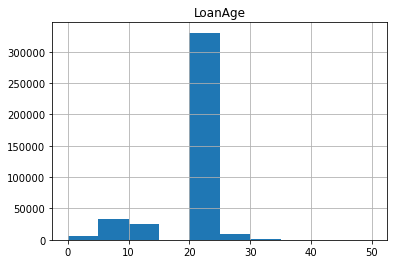

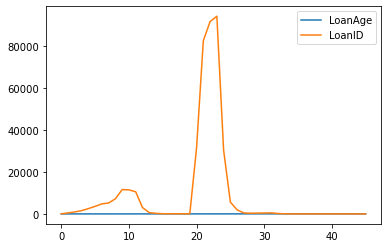

In [28]:
df_per_1loan.hist(column='LoanAge')
loan_age=df_per_1loan[['LoanAge','LoanID']].groupby('LoanAge',as_index=False).count()
loan_age.plot.line()

In [6]:
acq_fnames='gs://mchrestkha-github-ml-examples/fannie_mae_loans/acq/Acquisition_2016*'
perf_fnames='gs://mchrestkha-github-ml-examples/fannie_mae_loans/perf/Performance_2016*'




In [ ]:
!gsutil du -sh 'gs://mchrestkha-github-ml-examples/fannie_mae_loans/acq/'
!gsutil du -sh 'gs://mchrestkha-github-ml-examples/fannie_mae_loans/perf/'

## Dask

In [ ]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
# num_workers=24
# threads_per_worker=2
# cluster = LocalCluster(n_workers=num_workers, threads_per_worker=threads_per_worker)

client = Client(cluster)
client

In [ ]:
%%time
#acq_ddf=dask_df.read_csv(fnames,sep='|',names=col_acq, assume_missing=True)
perf_ddf=dask_df.read_csv(perf_fnames,sep='|',names=col_per, assume_missing=True, dtype=dtype)
rows=perf_ddf.shape[0].compute()
cols=perf_ddf.shape[1]
print(rows,',', cols) 

## Dask_cuDF

In [1]:
from dask_cuda import LocalCUDACluster
from dask.distributed import Client
# Create a Dask Cluster with one worker per GPU
num_workers=2
threads_per_worker=2
cluster = LocalCUDACluster(n_workers=num_workers, threads_per_worker=threads_per_worker)
#cluster = LocalCUDACluster()

client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:39687 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 2 Cores: 4 Memory: 358.77 GB


In [9]:
%%time
#acq_ddf=dask_df.read_csv(fnames,sep='|',names=col_acq, assume_missing=True)
perf_df=dask_cudf.read_csv(perf_fnames,sep='|',names=col_per, assume_missing=True, dtype=dtype_per)
rows=perf_df.shape[0].compute()
cols=perf_df.shape[1]
print(rows,',', cols) 

38386918 , 30
CPU times: user 429 ms, sys: 46 ms, total: 475 ms
Wall time: 15.2 s


In [ ]:
perf_df

In [ ]:
perf_df.shape

In [10]:
perf_df.head()

,LoanID,MonthRep,Servicer,CurrInterestRate,CAUPB,LoanAge,MonthsToMaturity,AdMonthsToMaturity,MaturityDate,MSA,...,ATFHP,NetSaleProceeds,CreditEnhProceeds,RPMWP,OFP,NIBUPB,PFUPB,RMWPF,FPWA,ServicingIndicator
0,100000512540,01/01/2017,<NA>,3.75,63700.48,12.0,348.0,347.0,01/2046,12260.0,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1,100000512540,02/01/2016,OTHER,3.75,<NA>,1.0,359.0,359.0,01/2046,12260.0,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2,100000512540,02/01/2017,<NA>,3.75,63597.86,13.0,347.0,346.0,01/2046,12260.0,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
3,100000512540,03/01/2016,<NA>,3.75,<NA>,2.0,358.0,357.0,01/2046,12260.0,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
4,100000512540,03/01/2017,<NA>,3.75,63494.92,14.0,346.0,345.0,01/2046,12260.0,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


In [ ]:
%%time
df = dask_cudf.read_csv(perf_fnames,sep='|',names=col_acq)
df.shape

## Pandas

In [ ]:
acq_fnames='gs://mchrestkha-github-ml-examples/fannie_mae_loans/acq/*.csv'
perf_fnames='gs://mchrestkha-github-ml-examples/fannie_mae_loans/perf/*'

import glob
files = glob.glob(acq_fnames)
files

In [ ]:
start_time = time.time()
df=pd.read_csv(filname, header=None, names=colnames)
print("[INFO]: ------ Data Ingestion is completed in {} seconds ---".format((time.time() - start_time)))
start_time = time.time()
X = df[df.columns.difference(['label'])]
y = df['label']
dtrain=xgb.DMatrix(X,y)
print("[INFO]: ------ DMatrix is completed in {} seconds ---".format((time.time() - start_time)))


start_time = time.time()
param =  {
               'max_depth': 8,
               'objective': 'reg:squarederror',
               'tree_method': 'hist'
             }
bst = xgb.train(param, dtrain,num_boost_round=100)
print("[INFO]: ------ Training is completed in {} seconds ---".format((time.time() - start_time)))

## cuDF

In [ ]:
start_time = time.time()
df=cudf.read_csv(filname, header=None, names=colnames)
print("[INFO]: ------ Data Ingestion is completed in {} seconds ---".format((time.time() - start_time)))
start_time = time.time()
X = df[df.columns.difference(['label'])]
y = df['label']
dtrain=xgb.DMatrix(X,y)
print("[INFO]: ------ DMatrix is completed in {} seconds ---".format((time.time() - start_time)))

start_time = time.time()
param =  {
               'max_depth': 8,
               'objective': 'reg:squarederror',
               'tree_method': 'gpu_hist'
             }
bst = xgb.train(param, dtrain,num_boost_round=100)
print("[INFO]: ------ Training is completed in {} seconds ---".format((time.time() - start_time)))